In [1]:
from yahooquery import Ticker
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Activation
from tfkan.layers import DenseKAN
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

2025-12-03 12:24:57.449730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 12:24:57.449758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 12:24:57.450617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-03 12:24:57.455592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 12:24:58.063002: W tensorflow/compiler/tf2

In [2]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"   # ensures deterministic ops
os.environ["TF_CUDNN_DETERMINISTIC"] = "1" # ensures deterministic cuDNN kernels
from tensorflow.keras import backend as K
tf.config.experimental.enable_op_determinism()

In [5]:
symbol = 'AAPL'
ticker = Ticker(symbol)
data = ticker.history(start='2000-01-01', end='2025-10-31', interval='1d')
prices = data.xs(symbol, level=0)['close']
prices.index = pd.to_datetime(prices.index)

In [6]:
train = prices.loc[:'2024-12']
test = prices.loc['2025-01':]

print(f"Training data: {len(train)} samples")
print(f"Test data: {len(test)} samples")

Training data: 6289 samples
Test data: 208 samples


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

In [8]:
def create_sequences(data, timestep=120):
    X, y = [], []
    for i in range(timestep, len(data)):
        X.append(data[i-timestep:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [9]:
X_train, y_train_prices = create_sequences(train_scaled, 120)

In [10]:
train_last_days = train_scaled[-120:]
test_input_data = np.concatenate([train_last_days, test_scaled], axis=0)
X_test, y_test_prices = create_sequences(test_input_data, 120)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [12]:
y_train_last = X_train[:, -1, 0]
y_train = np.column_stack([y_train_prices, y_train_last])

In [13]:
y_test_last = X_test[:, -1, 0]
y_test = np.column_stack([y_test_prices, y_test_last])

In [14]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6169, 120, 1)
y_train shape: (6169, 2)
X_test shape: (208, 120, 1)
y_test shape: (208, 2)


In [15]:
def custom_loss(y_true, y_pred):
    """
    Wiener/GBM process loss
    y_true[:, 0] = actual next price
    y_true[:, 1] = last price in window (S_t)
    y_pred[:, 0] = mu (drift)
    y_pred[:, 1] = log_sigma (log volatility)
    """
    mu = y_pred[:, 0]
    sigma = tf.exp(y_pred[:, 1])
    S_t = y_true[:, 1]
    Z = tf.random.normal(tf.shape(mu))
    S_pred = S_t * tf.exp(mu - 0.5 * sigma**2 + sigma * Z)
    return tf.reduce_mean(tf.square(S_pred - y_true[:, 0]))

In [16]:
model = tf.keras.Sequential([
    DenseKAN(units=32, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.LSTM(128, activation='elu', return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2)  # [mu, log_sigma]
])

2025-12-03 12:25:01.201383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-03 12:25:01.234014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-03 12:25:01.234219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=custom_loss,
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_kan (DenseKAN)        (None, 120, 32)           332       
                                                                 
 activation (Activation)     (None, 120, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 83022 (324.30 KB)
Trainable params: 83010 (324.26 KB)
Non-trainable params: 12 (48.00 Byte)
_________________________________________________________________


In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_kan_lstm_model.h5', monitor='val_loss', save_best_only=True
)

In [20]:
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    batch_size=32,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Training model...
Epoch 1/250


2025-12-03 12:25:05.810741: I external/local_xla/xla/service/service.cc:168] XLA service 0x71d3112e1160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-03 12:25:05.810760: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-12-03 12:25:05.815565: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 12:25:05.829247: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1764786305.901632  301514 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


193/193 [==============================] - 66s 325ms/step - loss: 0.0039 - mean_squared_error: 3.8217 - val_loss: 0.0014 - val_mean_squared_error: 13.0298
Epoch 2/250


/home/cs/grad/dasj/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


193/193 [==============================] - 69s 358ms/step - loss: 2.6692e-04 - mean_squared_error: 7.1440 - val_loss: 3.7285e-04 - val_mean_squared_error: 14.9509
Epoch 3/250
193/193 [==============================] - 69s 358ms/step - loss: 1.7988e-04 - mean_squared_error: 9.3132 - val_loss: 3.9482e-04 - val_mean_squared_error: 16.4115
Epoch 4/250
193/193 [==============================] - 69s 359ms/step - loss: 1.0541e-04 - mean_squared_error: 12.2520 - val_loss: 3.6120e-04 - val_mean_squared_error: 19.9990
Epoch 5/250
193/193 [==============================] - 69s 358ms/step - loss: 7.7013e-05 - mean_squared_error: 14.8618 - val_loss: 9.3843e-04 - val_mean_squared_error: 25.0964
Epoch 6/250
193/193 [==============================] - 69s 359ms/step - loss: 7.3168e-05 - mean_squared_error: 14.4413 - val_loss: 4.0322e-04 - val_mean_squared_error: 25.0991
Epoch 7/250
193/193 [==============================] - 69s 359ms/step - loss: 4.4629e-05 - mean_squared_error: 17.2657 - val_loss: 3.2

In [21]:
def predict_with_formula(model, X, num_simulations=100):
    predictions = model.predict(X, verbose=0)
    mu = predictions[:, 0]
    sigma = np.exp(predictions[:, 1])
    S_t = X[:, -1, 0]
    
    predicted_prices = []
    for i in range(len(X)):
        sim_prices = []
        for _ in range(num_simulations):
            Z = np.random.randn()
            S_next = S_t[i] * np.exp(mu[i] - 0.5 * sigma[i]**2 + sigma[i] * Z)
            sim_prices.append(S_next)
        predicted_prices.append(np.mean(sim_prices))
    
    return np.array(predicted_prices), mu, sigma

In [22]:
y_pred_scaled, mu_test, sigma_test = predict_with_formula(model, X_test, num_simulations=100)

# Inverse transform
y_pred_original = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_actual_original = scaler.inverse_transform(y_test_prices.reshape(-1, 1))

In [23]:
y_pred_original = y_pred_original[1:]
y_actual_original = pd.DataFrame(y_actual_original).shift(1).dropna().values.flatten()

In [24]:
mse = mean_squared_error(y_actual_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual_original, y_pred_original)
r2 = r2_score(y_actual_original, y_pred_original)
mape = np.mean(np.abs((y_actual_original - y_pred_original) / y_actual_original)) * 100

print(f"\nTest Set Performance:")
print(f"  MSE: ${mse:.5f}")
print(f"  RMSE: ${rmse:.5f}")
print(f"  MAE: ${mae:.5f}")
print(f"  R² Score: {r2:.5f}")
print(f"  MAPE: {mape:.5f}%")
print(f"  Mean μ (drift): {np.mean(mu_test):.6f}")
print(f"  Mean σ (volatility): {np.mean(sigma_test):.6f}")


Test Set Performance:
  MSE: $0.02308
  RMSE: $0.15190
  MAE: $0.14768
  R² Score: 0.99994
  MAPE: 10.26474%
  Mean μ (drift): 0.000673
  Mean σ (volatility): 0.000874


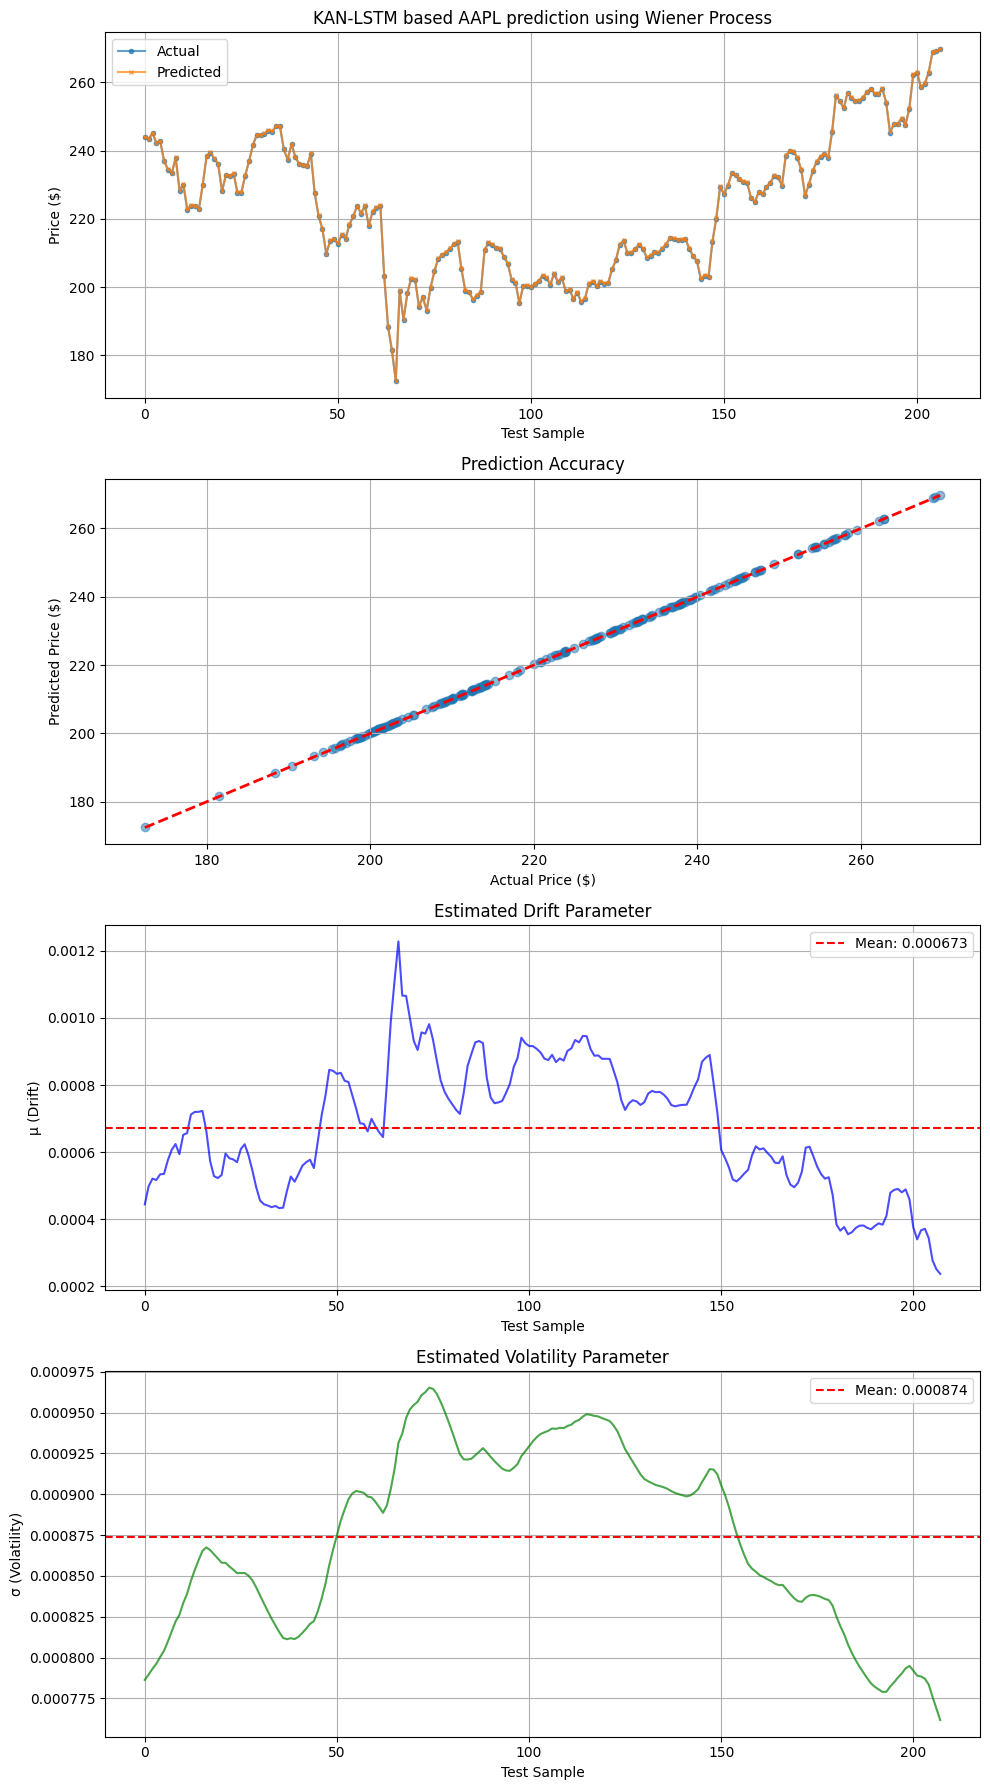

In [25]:
fig, axes = plt.subplots(4, 1, figsize=(10, 18))


# Plot 1: Actual vs Predicted
axes[0].plot(y_actual_original, label='Actual', marker='o', markersize=3, alpha=0.7)
axes[0].plot(y_pred_original, label='Predicted', marker='x', markersize=3, alpha=0.7)
axes[0].set_xlabel('Test Sample')
axes[0].set_ylabel('Price ($)')
axes[0].set_title(f'KAN-LSTM based {symbol} prediction using Wiener Process')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Scatter Plot
axes[1].scatter(y_actual_original, y_pred_original, alpha=0.5)
axes[1].plot([y_actual_original.min(), y_actual_original.max()],
                [y_actual_original.min(), y_actual_original.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].set_title('Prediction Accuracy')
axes[1].grid(True)

# Plot 3: Drift (μ)
axes[2].plot(mu_test, color='blue', alpha=0.7)
axes[2].axhline(y=np.mean(mu_test), color='r', linestyle='--', label=f'Mean: {np.mean(mu_test):.6f}')
axes[2].set_xlabel('Test Sample')
axes[2].set_ylabel('μ (Drift)')
axes[2].set_title('Estimated Drift Parameter')
axes[2].legend()
axes[2].grid(True)

# Plot 4: Volatility (σ)
axes[3].plot(sigma_test, color='green', alpha=0.7)
axes[3].axhline(y=np.mean(sigma_test), color='r', linestyle='--', label=f'Mean: {np.mean(sigma_test):.6f}')
axes[3].set_xlabel('Test Sample')
axes[3].set_ylabel('σ (Volatility)')
axes[3].set_title('Estimated Volatility Parameter')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()